# Problem Statement: Using Logistic Regression to classify fuel types in residential storages

# Exploratory Data Analysis 

In [1296]:
import pandas as pd
import numpy as np
import seaborn as sns

In [1297]:
#df = pd.read_excel(r'C:\Users\U355394\Downloads\EnergyStorage_April2024.xlsx')
df = pd.read_excel(r'C:\Users\U355394\Downloads\EnergyStorage_April2024.xlsx')

### Initial Data Exploration


In [1298]:
df.head()

,Utility,Nameplate Capacity (in KW AC),Fuel Type,Facility City,County,CAISO Flag,Facility Zip,Customer Sector,Approval Date
0,Pacific Gas & Electric,4.85,Electric Grid_ Solar,Acampo,San Joaquin,OTHER,95220,Residential,2017-07-11
1,San Diego Gas & Electric,5.00,Battery,Alpine,San Diego,OTHER,91901,Residential,2022-04-15
2,San Diego Gas & Electric,10.00,Battery,Alpine,San Diego,OTHER,91901,Residential,2022-04-15
3,San Diego Gas & Electric,15.00,Battery,Alpine,San Diego,OTHER,91901,Residential,2022-04-18
4,San Diego Gas & Electric,9.00,Battery,Alpine,San Diego,OTHER,91901,Residential,2022-04-19


In [1299]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,Utility,Nameplate Capacity (in KW AC),Fuel Type,Facility City,County,CAISO Flag,Facility Zip,Customer Sector,Approval Date
9,San Diego Gas & Electric,15.00,Battery,Alpine,San Diego,OTHER,91901,Residential,2022-05-12
21,San Diego Gas & Electric,10.00,Battery,Alpine,San Diego,OTHER,91901,Residential,2022-07-05
55,San Diego Gas & Electric,15.00,Battery,Alpine,San Diego,OTHER,91901,Residential,2022-12-15
58,San Diego Gas & Electric,10.00,Battery,Alpine,San Diego,OTHER,91901,Residential,2023-01-12
116,Pacific Gas & Electric,2.56,Onsite Renewable_ Solar,Castro Valley,Alameda,OTHER,94552,Residential,2023-06-20
...,...,...,...,...,...,...,...,...,...
153968,Sacramento Municipal Utility District,5.00,Battery,Elk Grove,Sacramento,OTHER,95757,Residential,2023-01-31
153978,Sacramento Municipal Utility District,5.00,Battery,Folsom,Sacramento,OTHER,95630,Residential,2023-05-23
153987,Sacramento Municipal Utility District,5.00,Battery,Folsom,Sacramento,OTHER,95630,Residential,2023-05-04
154056,Sacramento Municipal Utility District,5.00,Battery,Sacramento,Sacramento,OTHER,95822,Residential,2023-12-19


Identifying different column types:

In [1300]:
df.dtypes


Utility                                  object
Nameplate Capacity (in KW AC)           float64
Fuel Type                                object
Facility City                            object
County                                   object
CAISO Flag                               object
Facility Zip                              int64
Customer Sector                          object
Approval Date                    datetime64[ns]
dtype: object

In [1301]:
df['CAISO Flag'].unique()

array(['OTHER', 'CAISO BESS', 'CAISO Hybrid', 'Planned CAISO'],
      dtype=object)

In [1302]:
df['CAISO Flag'].value_counts()

CAISO Flag
OTHER            154008
CAISO BESS          127
Planned CAISO        58
CAISO Hybrid         20
Name: count, dtype: int64

High dominance of the 'Other' category in the 'CAISO Flag' column

In [1303]:
(df[df['CAISO Flag'] == 'OTHER'].shape[0] / df.shape[0]) * 100 

99.86706697878908

**Note:** since about **99.87%** of the **CAISO Flag** column has value OTHER, we remove the column. 

Our categorical columns have a lot of classes. Some are redundant such as County, Facility Zip, and Facility City.


In [1304]:
categorical_columns = ['Utility', 'Fuel Type', 'Facility City', 'County', 'Facility Zip', 'Customer Sector']

for col in categorical_columns:
    print(f"Number of unique values in: {col}")
    print(len(df[col].unique()))

Number of unique values in: Utility
27
Number of unique values in: Fuel Type
43
Number of unique values in: Facility City
1220
Number of unique values in: County
59
Number of unique values in: Facility Zip
1592
Number of unique values in: Customer Sector
3


We remove the following location fields: Facility city and Facility Zip since they have a significantly high number of classes


In [1305]:
df = df.drop(columns=['Facility Zip', 'Facility City'])

In [1306]:
df['Customer Sector'].value_counts()

Customer Sector
Residential    151203
Commercial       2777
Utility           233
Name: count, dtype: int64

In [1307]:
(df[df['Customer Sector'] == 'Residential'].shape[0] / df.shape[0]) * 100 

98.04815417636645

99% of the customer sector is residential. Let's only retain this class

In [1308]:
df = df[df['Customer Sector'] == 'Residential']

In [1309]:
df['Fuel Type'].value_counts()

Fuel Type
Battery                                        70766
Onsite Renewable_ Solar                        42497
Electric Grid_ Solar                           26557
Solar PV                                        8589
Electric Grid                                    825
Solar PV & Battery                               684
Electric Grid_ Onsite Renewable_ Solar           489
Onsite Renewable                                 204
Electric Grid_ Wind                              167
Behind Customer Meter                            103
customer dispatched                               58
Onsite Renewable_ Wind                            51
Electric Grid_ Onsite Renewable                   45
Peak Shaving/Demand Management                    29
Electric Grid_ Solar_ Wind                        29
Other_ Solar                                      27
Onsite Renewable_ Solar_ Wind                     23
Solar_ Wind                                       22
Other                               

**Note:** we create a new column "Fuel_Type_v2" that contains the following categories: 

- Nonsolar (when "Fuel Type" has values "Battery" or "Electric Grid")
- Solar (when "Fuel Type" has values "Onsite Renewable_ Solar" or "Electric Grid_ Solar" or "Solar PV")

In [1310]:
import numpy as np
# Define the conditions for the new column 'Fuel_Type_v2'
conditions = [
    df["Fuel Type"].isin(["Battery", "Electric Grid"]),
    df["Fuel Type"].isin(["Onsite Renewable_ Solar", "Electric Grid_ Solar", "Solar PV"])
]

# Define the corresponding values for the new column 'Fuel_Type_v2'
values = ["Nonsolar", "Solar"]

# Create the new column 'Fuel_Type_v2' using np.select()
df["Fuel_Type_v2"] = pd.Series(np.select(conditions, values, default="Other"))

df

,Utility,Nameplate Capacity (in KW AC),Fuel Type,County,CAISO Flag,Customer Sector,Approval Date,Fuel_Type_v2
0,Pacific Gas & Electric,4.85,Electric Grid_ Solar,San Joaquin,OTHER,Residential,2017-07-11,Solar
1,San Diego Gas & Electric,5.00,Battery,San Diego,OTHER,Residential,2022-04-15,Nonsolar
2,San Diego Gas & Electric,10.00,Battery,San Diego,OTHER,Residential,2022-04-15,Nonsolar
3,San Diego Gas & Electric,15.00,Battery,San Diego,OTHER,Residential,2022-04-18,Nonsolar
4,San Diego Gas & Electric,9.00,Battery,San Diego,OTHER,Residential,2022-04-19,Nonsolar
...,...,...,...,...,...,...,...,...
154208,Sacramento Municipal Utility District,1.28,Battery,Sacramento,OTHER,Residential,2023-12-19,NaN
154209,Sacramento Municipal Utility District,1.04,Battery,Sacramento,OTHER,Residential,2018-03-08,NaN
154210,Sacramento Municipal Utility District,0.54,Battery,Sacramento,OTHER,Residential,2022-09-30,NaN
154211,Sacramento Municipal Utility District,0.27,Battery,Sacramento,OTHER,Residential,2019-05-17,NaN


In [1311]:
df['Utility'].value_counts()

Utility
Pacific Gas & Electric                       73017
Southern California Edison                   47153
San Diego Gas & Electric                     21474
Los Angeles Department of Water and Power     6378
Sacramento Municipal Utility District         1524
Modesto Irrigation District                    420
Pasadena                                       289
City of Glendale                               165
Alameda                                        135
City of Riverside                              124
Palo Alto                                      103
Roseville                                      102
City of Healdsburg                              63
Anaheim                                         60
PacifiCorp                                      58
Truckee                                         35
Silicon Valley Power                            29
Burbank                                         28
Lodi Electric Utility                           25
Colton                 

**Note:** create a new column "Utility_v2" that contains just 3 company names: 

- PGE
- Southern Cali Edison (SCE)
- San Diego Gas & E (SDGE)

In [1312]:
# Define the conditions for the new column 'Utility_v2'
utility_conditions = [
    df["Utility"].str.contains("Pacific Gas & Electric"),
    df["Utility"].str.contains("Southern California Edison"),
    df["Utility"].str.contains("San Diego Gas & Electric")
]

# Define the corresponding values for the new column 'Utility_v2'
utility_values = ["PGE", "SCE", "SDGE"]

# Create the new column 'Utility_v2' using np.select()
df["Utility_v2"] = pd.Series(np.select(utility_conditions, utility_values, default="Other"))
# Filter the DataFrame to only keep the values equal to either of the 3 utilities


In [1313]:
df.Utility_v2.unique()

array(['PGE', 'SDGE', 'Other', 'SCE', nan], dtype=object)

Let's only retain Solar and Nonsolar classes for Fuel Types. Both classes represent 97% of the total records.




In [1314]:
df.Fuel_Type_v2.value_counts()

Fuel_Type_v2
Solar       76638
Nonsolar    70581
Other        1942
Name: count, dtype: int64

In [1315]:
(df[df['Fuel_Type_v2'] == 'Nonsolar'].shape[0] / df.shape[0]) * 100 

46.679629372433084

In [1316]:
(df[df['Fuel_Type_v2'] == 'Solar'].shape[0] / df.shape[0]) * 100 

50.68550227178032

The majority of solar fuel type storages are from PGE. SCE occupies the majority of non solar storages. PGE also represents any other fuel types outside of these two



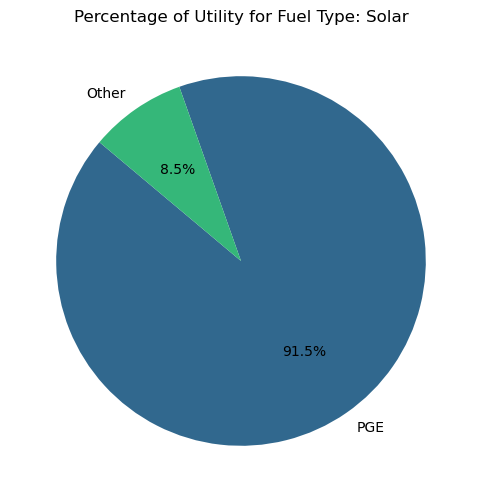

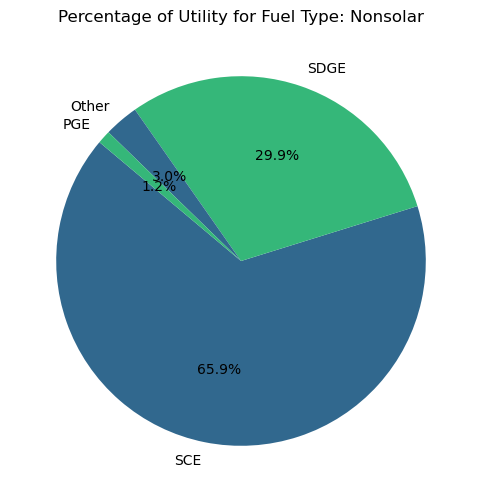

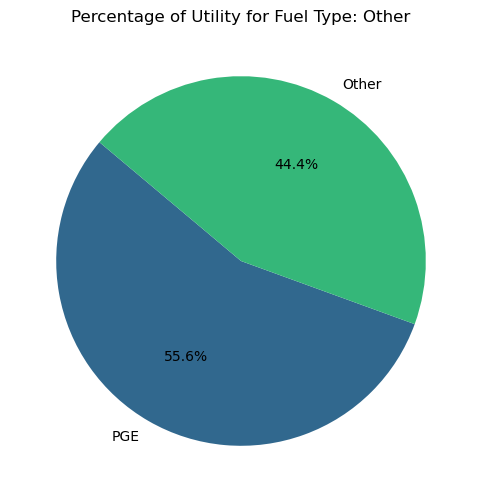

In [1317]:
import matplotlib.pyplot as plt
# Remove rows where 'Fuel_Type_v2' is NaN
df = df.dropna(subset=['Fuel_Type_v2'])
fuel_types = df['Fuel_Type_v2'].unique()
# Plot pie chart for each fuel type
for fuel in fuel_types:
    # Filter data for the current fuel type
    fuel_data = df[df['Fuel_Type_v2'] == fuel]
    
    # Count occurrences of each utility within the current fuel type
    utility_counts = fuel_data['Utility_v2'].value_counts()
    
    # Plot pie chart for current fuel type
    plt.figure(figsize=(6, 6))
    plt.pie(utility_counts, labels=utility_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f"Percentage of Utility for Fuel Type: {fuel}")
    plt.show()

In [1318]:
df = df.drop(columns=['CAISO Flag', 'Fuel Type', 'Utility','Customer Sector'])

We create a year column to check median Nameplate Capacity by year:


In [1319]:
# Create a year column by extracting the year from the 'approval date' column
df['Year_Approval_Date'] = pd.to_datetime(df['Approval Date']).dt.year
df = df.drop(columns=['Approval Date'])

By creating this graph, we notice that the median name plate capacity changes by year of approval date. There has been more volatility in terms of name plate capacity from 2010 to 2014.


In [1421]:
df.groupby('Year_Approval_Date')['Nameplate Capacity (in KW AC)'].median()

Year_Approval_Date
2010    1.609438
2011    2.451005
2012    1.956012
2013    1.916923
2014    1.527794
2015    1.735828
2016    1.551495
2017    1.609438
2018    1.609438
2019    1.609438
2020    1.791759
2021    1.791759
2022    1.609638
2023    1.609438
2024    1.700599
Name: Nameplate Capacity (in KW AC), dtype: float64

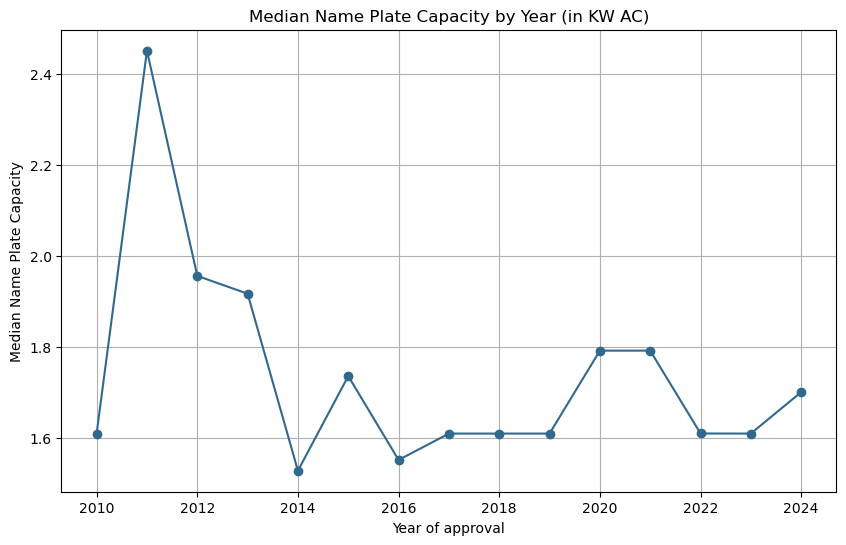

In [1422]:
# Calculate the median name plate capacity by year
median_capacity_by_year = df.groupby('Year_Approval_Date')['Nameplate Capacity (in KW AC)'].median()

# Plot the median evolution year by year
plt.figure(figsize=(10, 6))
median_capacity_by_year.plot(kind='line', marker='o')
plt.title('Median Name Plate Capacity by Year (in KW AC)')
plt.xlabel('Year of approval')
plt.ylabel('Median Name Plate Capacity')
plt.grid(True)
plt.show()

Non solar has a higher median name plate capacity than Solar and other fuel types


In [1321]:
df.groupby('Fuel_Type_v2')['Nameplate Capacity (in KW AC)'].median()

Fuel_Type_v2
Nonsolar    6.000
Other       5.001
Solar       5.000
Name: Nameplate Capacity (in KW AC), dtype: float64

The target variable is right skewed, therefore we might need to apply data transformation later on

array([[<Axes: title={'center': 'Nameplate Capacity (in KW AC)'}>,
        <Axes: title={'center': 'Year_Approval_Date'}>]], dtype=object)

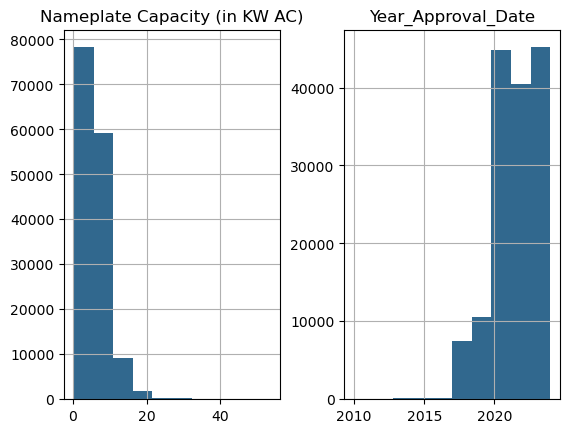

In [1322]:
df.hist()

Certain counties are overrepresented in the data

In [1323]:
df.County.value_counts()

County
Los Angeles        19338
San Diego          19067
Riverside          10376
Orange             10121
Santa Clara         9884
Contra Costa        8569
Alameda             8313
San Bernardino      7638
Ventura             5399
Sonoma              5197
San Mateo           4993
Marin               4475
Kern                2841
San Luis Obispo     2769
Solano              2570
El Dorado           2541
San Joaquin         2409
Placer              2326
Fresno              2291
Santa Barbara       2057
Santa Cruz          1968
Napa                1529
Monterey            1243
Yolo                 979
San Francisco        962
Tulare               864
Nevada               864
Butte                843
Madera               641
Humboldt             611
Calaveras            531
Merced               526
Lake                 512
Amador               490
Tuolumne             434
Stanislaus           425
Yuba                 417
Shasta               348
Kings                340
Sutter            

Only select certain major counties

In [1324]:
# Get the count of records for each county
county_counts = df.County.value_counts()

# Filter counties that have exactly 7000 records
counties_with_7000_records = county_counts[county_counts >= 7000].index

# Retain only the rows in the DataFrame that belong to these counties
filtered_df = df[df.County.isin(counties_with_7000_records)]

# Display the filtered DataFrame
df = filtered_df.copy()

In [1325]:
df.County.value_counts()

County
Los Angeles       19338
San Diego         19067
Riverside         10376
Orange            10121
Santa Clara        9884
Contra Costa       8569
Alameda            8313
San Bernardino     7638
Name: count, dtype: int64

In [1326]:
target='County'
df = df.groupby(target, group_keys=False)
df = pd.DataFrame(df.apply(lambda x: x.sample(df.size().min())))
df['County'].value_counts()

County
Alameda           7638
Contra Costa      7638
Los Angeles       7638
Orange            7638
Riverside         7638
San Bernardino    7638
San Diego         7638
Santa Clara       7638
Name: count, dtype: int64

# Feature Engineering: 

We create a variable for the yearly median name plate rating, as it might help predict the name plate rating of a project

In [1327]:
median_name_plate_rating = df.groupby('Year_Approval_Date')['Nameplate Capacity (in KW AC)'].transform('median')
df['Median_Name_Plate_Rating_Year'] = median_name_plate_rating

In [1328]:
df.columns

Index(['Nameplate Capacity (in KW AC)', 'County', 'Fuel_Type_v2', 'Utility_v2',
       'Year_Approval_Date', 'Median_Name_Plate_Rating_Year'],
      dtype='object')

# Pre-processing

### Taking the class with minimum value

In [1330]:
df = df[df['Fuel_Type_v2'] !='Other']

In [1331]:
df['Nameplate Capacity (in KW AC)'].dtype

dtype('float64')

In [1333]:
df = df.reset_index()

In [1334]:
target='Fuel_Type_v2'
df = df.groupby(target, group_keys=False)
df = pd.DataFrame(df.apply(lambda x: x.sample(df.size().min())))
df['Fuel_Type_v2'].value_counts()

Fuel_Type_v2
Nonsolar    25970
Solar       25970
Name: count, dtype: int64

We transform the data to avoid bias in the target variable:

<Axes: >

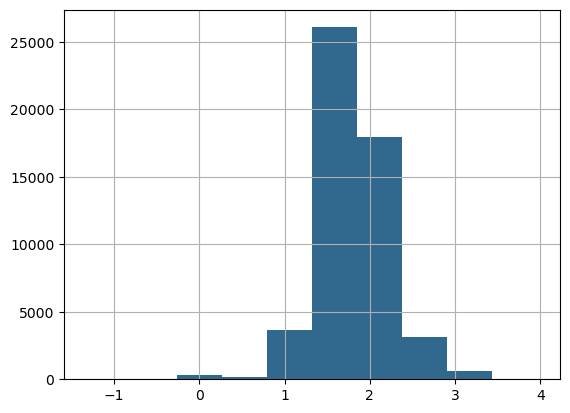

In [1335]:
df['Nameplate Capacity (in KW AC)'] = np.log(df['Nameplate Capacity (in KW AC)'])
df['Nameplate Capacity (in KW AC)'].hist()

In [1390]:
df

,index,Nameplate Capacity (in KW AC),County,Fuel_Type_v2,Utility_v2,Year_Approval_Date,Median_Name_Plate_Rating_Year
25983,70583,1.345472,Orange,Nonsolar,SDGE,2022,5.001
33314,127712,2.151762,Riverside,Nonsolar,SCE,2022,5.001
26481,147766,1.609438,Orange,Nonsolar,SCE,2023,5.000
41067,119534,2.302585,San Bernardino,Nonsolar,SCE,2021,6.000
42593,122401,2.302585,San Bernardino,Nonsolar,SCE,2022,5.001
...,...,...,...,...,...,...,...
6076,97945,1.599388,Alameda,Solar,PGE,2020,6.000
11051,8590,2.302585,Contra Costa,Solar,PGE,2022,5.001
6826,27424,0.940007,Alameda,Solar,PGE,2023,5.000
6871,54672,2.302585,Alameda,Solar,PGE,2023,5.000


Selecting Target and Explanatory Variables: There are not that many explanatory variables in the data, therefore I selected the remaining variables, and ran my model with different variable combinations to identify potential overfitting or underfitting. The model was strongly overfitting when using the utility column, so it was removed.

In [1412]:
# Automatically select all columns except 'pitch_type'
# Select features (X) and the target variable (y) using the filtered columns
X = df.loc[:,['County', 'Nameplate Capacity (in KW AC)', 'Median_Name_Plate_Rating_Year', 'Year_Approval_Date']]
y = df['Fuel_Type_v2']

Training and testing sets

In [1413]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
 X,
 y,
 test_size=0.2,
 random_state=4
)


Encoding and scaling Variables

In [1414]:
scaler = StandardScaler()
# Split the data into categorical and numerical sets
X_train_categorical = pd.get_dummies(x_train.select_dtypes(include=['object', 'category']))
X_train_numerical = x_train.select_dtypes(include=['int', 'float']) # Keep
# Concatenate the numerical and encoded categorical columns
x_train = pd.concat([X_train_numerical, X_train_categorical], axis=1)
x_train = pd.DataFrame(
scaler.fit_transform(x_train),
columns = x_train.columns
)


# Split the data into categorical and numerical sets
X_test_categorical = pd.get_dummies(x_test.select_dtypes(include=['object', 'category']))
X_test_numerical = x_test.select_dtypes(include=['int', 'float']) # Keep nu
# Concatenate the numerical and encoded categorical columns
x_test = pd.concat([X_test_numerical, X_test_categorical], axis=1)
x_test = pd.DataFrame(
scaler.fit_transform(x_test),
columns = x_test.columns
)

One-hot encode target

In [1415]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).argmax(1)
y_test_encoded = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).argmax(1)


c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [1416]:
x_train.shape

(41552, 11)

In [1417]:
y_train.shape

(41552,)

In [1418]:
y_test_encoded

array([1, 1, 0, ..., 0, 1, 1], dtype=int64)

Using Logistic Regression with Lasso regularization helps streamline feature
selection and prevent overfitting. Lasso shrinks less important feature
coefficients to zero, allowing us to focus only on the most influential variables.
This improves model simplicity and interpretability.
Cross-validation ensures we select the optimal regularization strength

In [1419]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Lasso (L1) Regularization with Cross-Validation
model = LogisticRegressionCV(
Cs=10, # Number of regularization strengths to test
cv=5, # 5-fold cross-validation
penalty='l1', # Lasso (L1) regularization
solver='liblinear', # L1 requires liblinear solver
max_iter=100,
scoring='accuracy', # Use accuracy to choose the best model
random_state=42
)
# Fit the model with cross-validation
model.fit(x_train, y_train_encoded)
# Make predictions
y_pred = model.predict(x_test)

The model seems to perform well in terms in terms of classification. with a 85% accuracy on average. We find a high true positive rates for both classes: 4768 correct predictions for Nonsolar, and 3977 for solar/ Some misclassifications are present: with most of them being 1250 False negatives. This affect the recall for the 'Solar' class.

              precision    recall  f1-score   support

           0       0.79      0.92      0.85      5161
           1       0.91      0.76      0.83      5227

    accuracy                           0.84     10388
   macro avg       0.85      0.84      0.84     10388
weighted avg       0.85      0.84      0.84     10388



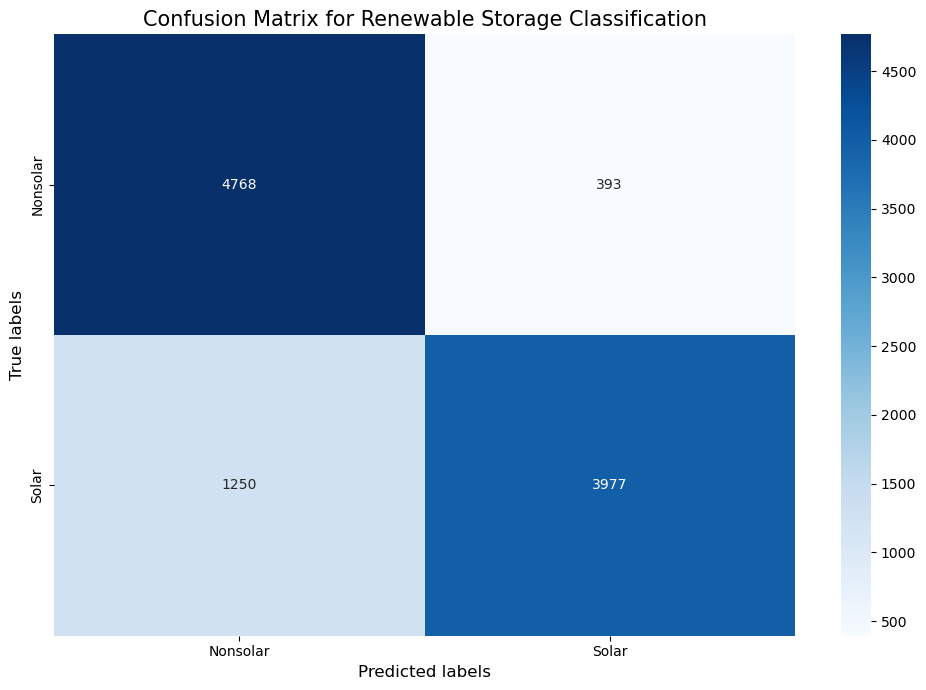

In [1420]:
# Generate a classification report
print(classification_report(y_test_encoded, y_pred))
# Create confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)
Storage_type = encoder.categories_[0] # This will give the storage type names
# Assuming "Nonsolar" corresponds to 0 and "Solar" corresponds to 1
class_names = ["Nonsolar", "Solar"]

# Convert confusion matrix to DataFrame with class names
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and ticks
ax.set_xlabel('Predicted labels', fontsize=12)
ax.set_ylabel('True labels', fontsize=12)
ax.set_title('Confusion Matrix for Renewable Storage Classification', fontsize=15)

plt.tight_layout()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2c898b8c-bb39-44a2-8b37-762dd08ac048' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>